# import and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from labellines import labelLine, labelLines
import os
#annots = loadmat('C:\\Users\\llinc\\GitHub\\retina_personal\\0406\\merge\\merge_0224_HMM_RL_G2.5_5min_Q100_6.5mW.mat')
%matplotlib inline

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [3]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt


        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [4]:
def Spike_Time_Generater(rdt, dt, Garmma=1):
    rdt = rdt*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = 1-np.random.rand()
        while (the_random_number < p and counter < len(rdt)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(rdt):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
#         if remainer_c>=1 or remainer_c<=0:
#             print('shit!')
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

# activation function
def NL(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

# chose file

In [5]:
# exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0503'
# G = 4.5
# annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz.mat')

# exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0729'
# Fc = 8
# annots = loadmat(exp_folder+'\\merge\\'+'merge_0727_OUsmooth_Bright_UL_DR_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz.mat')

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408'
Fc_list = [2,4,7,10]
annots_list = []
for Fc in Fc_list:
    annots_list.append(loadmat(exp_folder+'\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2'))
dt = 0.01
x_list, v_list, tv_list, t_cor_list, T_list, rstate_list = [], [], [], [], [], []
sampling_rate = 20000
for annots in annots_list:
    TimeStamps =np.round(np.squeeze(annots['TimeStamps']))
    TimeStamps = TimeStamps.astype(int)
    x = annots['a_data'][0, TimeStamps[0]*sampling_rate:TimeStamps[1]*sampling_rate+1]
    x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/2), mode='reflect') / dt
    x = x[::int(sampling_rate*dt)]
    x = x.astype(float)
    x = (x -np.mean(x))/np.std(x)
    T = np.arange(1,len(x)+1)*dt
    pcells = [1,20,33,39,40,42,53]
    rstatecells = []
    for p in range(len(pcells)):
        rstate, _ = np.histogram(annots['Spikes'][0][pcells[p]-1]-TimeStamps[0], np.append(0,T))
        rstatecells.append(rstate.copy())
    rstate_list.append(rstatecells.copy())
    tv = ndimage.gaussian_filter1d(x, sigma=5, order=1, mode='reflect') / dt

    x_list.append(x.copy())
    tv_list.append(tv.copy())
    T_list.append(T.copy())
    x_cor = np.correlate(x, x, "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T[:len(x_cor)]-dt*3/2)
    t_cor_list.append(np.interp(0.5*max(x_cor),  x_cor, Taxis))

realInformation_list = [0]*len(pcells)
for p in range(len(pcells)):
    window = [-1,1] # second
    realInformation_list[p] = [0]*len(x_list)
    Uvox_ratio_list = []
    for i in range(len(x_list)):
        xstate,edge = EqualState(x_list[i], 6)
        vstate,edge = EqualState(tv_list[i], 6)
        timeshift, realInformation_list[p][i] = PIfunc(rstate_list[i][p], xstate, vstate, dt, window)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\

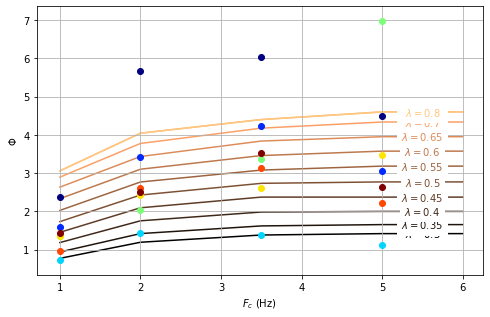

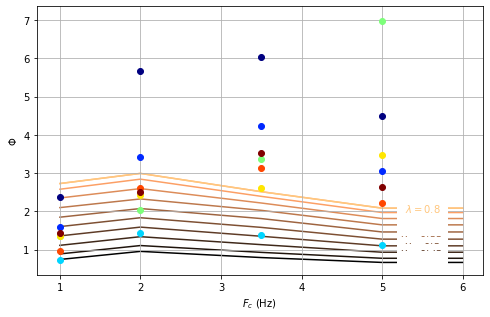

In [6]:
figList = []
dt = 0.01
for Dt in [0.2,0.3]:
    ##response
    # Model one: simple estimation
    window = [-1,1] # second
    # Lambdas = np.hstack((np.arange(0,100,20), np.arange(100,1000,100)))
    Lambdas =  np.arange(0.3,0.8,0.05)
    Ux_peaktime_list =[]
    Uv_peaktime_list = []
    Syn_peaktime_list = []
    Rdn_peaktime_list = []
    Ux_peakH_list =[]
    Uv_peakH_list = []
    Syn_peakH_list = []
    Rdn_peakH_list = []

    MIx_peakH_list = []
    MIv_peakH_list = []

    for i in range(len(annots_list)):
        Ux_peaktime =[]
        Uv_peaktime = []
        Syn_peaktime = []
        Rdn_peaktime = []
        Ux_peakH =[]
        Uv_peakH = []
        Syn_peakH = []
        Rdn_peakH = []

        MIx_peakH = []
        MIv_peakH = []

        x = x_list[i]
        tv = tv_list[i]
        for Lambda in Lambdas:
            v = np.append(np.zeros(int(Dt/dt)),x[int(Dt/dt):]-x[:-int(Dt/dt)])/Dt
            r = (1-Lambda)*x+v*Lambda
            #assign states
            r = NL(np.mean(r)-r, 0)
            ratio = sum(r)/T_list[i][-1]/12
            FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
            rstate, _ = np.histogram(FakeSpike, np.append(0,T_list[i]))
            #rstate = np.random.poisson(rstate)
            rstate = rstate.astype(int)
            xstate,edge = EqualState(x, 6)
            vstate,edge = EqualState(tv, 6)
            #calculate information
            timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)
            Ux = Information[('Beer','UIx')]
            Uv = Information[('Beer','UIv')]
            Syner = Information[('Beer','Syn')]
            Redun = Information[('Beer','Red')]
            #find peak
            Ux_peaktime.append( timeshift[int(np.mean(np.where(Ux == max(Ux))))])
            Uv_peaktime.append( timeshift[int(np.mean(np.where(Uv == max(Uv))))])
            Syn_peaktime.append( timeshift[int(np.mean(np.where(Syner == max(Syner))))])
            Rdn_peaktime.append( timeshift[int(np.mean(np.where(Redun == max(Redun))))])
            Ux_peakH.append( max(Ux))
            Uv_peakH.append( max(Uv))
            Syn_peakH.append( max(Syner))
            Rdn_peakH.append( max(Redun))
            MIx_peakH.append( max(Ux+Redun))
            MIv_peakH.append( max(Uv+Redun))

        Ux_peaktime_list.append(np.array(Ux_peaktime).copy())
        Uv_peaktime_list.append(np.array(Uv_peaktime).copy())
        Syn_peaktime_list.append(np.array(Syn_peaktime).copy())
        Rdn_peaktime_list.append(np.array(Rdn_peaktime).copy())
        Ux_peakH_list.append(np.array(Ux_peakH).copy())
        Uv_peakH_list.append(np.array(Uv_peakH).copy())
        Syn_peakH_list.append(np.array(Syn_peakH).copy())
        Rdn_peakH_list.append(np.array(Rdn_peakH).copy())

        MIx_peakH_list.append(np.array(MIx_peakH).copy())
        MIv_peakH_list.append(np.array(MIv_peakH).copy())



    model_Uvox_ratio_list_list = []
    Lambda_list = np.arange(0.3,0.85,0.05)
    for Lambda in Lambda_list:
        model_Uvox_ratio_list = []
        for i in range(len(Fc_list)):
            Uvox_ratio_table = ndimage.gaussian_filter1d(Uv_peakH_list[i]/Ux_peakH_list[i], sigma=1, mode='reflect')
            model_Uvox_ratio = np.interp(Lambda, Lambdas, Uvox_ratio_table)
            model_Uvox_ratio_list.append(model_Uvox_ratio.copy())
        model_Uvox_ratio_list_list.append(model_Uvox_ratio_list.copy())
    model_Uvox_ratio_list_list = np.array(model_Uvox_ratio_list_list)

    THEfig, THEax2 = plt.subplots()
    THEax2.set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(model_Uvox_ratio_list_list)))))
    pFc_list = np.append(Fc_list, 6.*2)
    for i in range(len(model_Uvox_ratio_list_list)):
        pmodel_Uvox_ratio = np.append((model_Uvox_ratio_list_list[i]), model_Uvox_ratio_list_list[i][-1])
        THEax2.plot(pFc_list/2, pmodel_Uvox_ratio, zorder=1, label=r'$\lambda=$'+str(np.round(Lambda_list[i],2)) )


    THEax2.set_xlabel(r'$F_{c}$ (Hz)')
    THEax2.set_ylabel(r'$\Phi$')
    THEax2.grid()
    fxvals = len(model_Uvox_ratio_list_list)*[5.5]
    fxvals.extend(len(model_Uvox_ratio_list_list)*[6.])
    labelLines(THEax2.get_lines(),zorder=2.5, xvals=fxvals)
    a = 4
    THEfig.set_size_inches(a*2, a*(np.sqrt(5)-1))
    
    Uvox_ratio_list_cells = []
    for p in range(len(pcells)):
        Uvox_ratio_list = []
        for i in range(len(x_list)):
            Uvox_ratio_table = ndimage.gaussian_filter1d(Uv_peakH_list[i]/Ux_peakH_list[i], sigma=1, mode='reflect')
            Uvox_ratio = max(realInformation_list[p][i][('Beer','UIv')])/max(realInformation_list[p][i][('Beer','UIx')])
            Uvox_ratio_list.append(Uvox_ratio)
        Uvox_ratio_list_cells.append(Uvox_ratio_list.copy())
    THEax2.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(pcells)))))
    for p in range(len(pcells)):
        THEax2.scatter(np.array(Fc_list)/2, np.array(Uvox_ratio_list_cells[p]), zorder=2 )
    figList.append(THEfig)

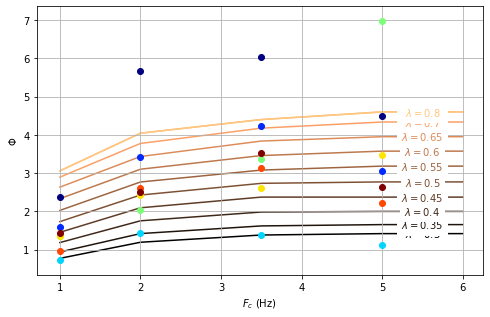

In [7]:
figList[0]

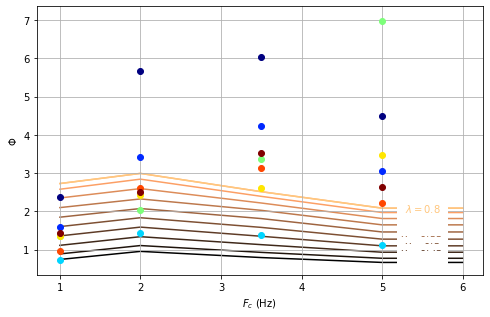

In [8]:
figList[1]

In [9]:
figList[2]

IndexError: list index out of range

In [ ]:
figList[3]

In [ ]:
figList[4]

In [ ]:
range(len(pcells))

# for paper

In [ ]:
import pandas as pd
data_df = pd.DataFrame(model_Uvox_ratio_list_list.T)

name  = 'PivsFc_0p2'
writer = pd.ExcelWriter('D:\\GoogleDrive\\retina\\PID_paper\\For Origin Plot\\'+name+'.xlsx')
# create and writer pd.DataFrame to excel
data_df.to_excel(writer,'0p2',float_format='%.5f') # float_format 控制精度
writer.save()

In [ ]:
model_Uvox_ratio_list_list.T